# Ordinary Differential Equations (ODEs) - Initial Value Problems (IVPs)

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

## Initial Value Problems (IVPs)

Before we start, let's define some useful notations. The class of problems we try to solve using Simwork is a subet of the ODEs problems where we want to solve for a quantity with the knowledge of its time derivative and its initial condition. These problems are called Initial Value Problems (IVPs) and have been extensively studied for at least the past two and a half centuries. They have the following form:

\begin{equation}
\dot y = f(y,t), \quad y(t_0) = y_0,
\end{equation}

where $y, y_0 \in \mathbb R^M$. Here $M$ corresponds to the **dimension** of the problem or, in other words, the number of unknowns. In our world, $M$ usually corresponds to the number of entities (or `BioReac` in Simwork).
$M$ can range from 1 to 500+ for very complex models. As a rule of thumb, the higher the $M$, the more difficult it is to solve the problem, but we'll come back to that later.

Other well-known types of ODEs are the Boundary Value Problems (BVPs) but this topic is beyond the scope of the present notebook.


## Numerical Methods to solve IVPs

### Generalities

Among the vast collection of methods used to solve IVPs problems, we shall focus here on the implicit Backward Differentiation Formula (BDF) family because it's one of the methods (and actually almost the only one) we use in practice. It has proved to be very robust and efficient when solving large and _stiff_ problems.

### The fixed-order fixed-timestep BDF scheme

To solve (1), the following discretization is proposed, where $t_n$ is the $n$-th discrete time point:

\begin{align}
y(t_n) &\simeq y^n, \\
f(y(t_n), t_n) &\simeq \beta f(y^n, t_n), \\
\dot y(t_n) &\simeq \frac{1}{h} \sum_{i=0}^{p} \alpha_i y^{n-i},
\end{align}

where $h$ is the current **step-size** $h = t^n - t^{n-1}$ and $p$ is the **order** of the method. The $p$-th order BDF scheme is usually referred to as BDF-p.
In practice, only the methods from BDF-1 (a.k.a _implicit Euler_) to BDF-6 (BDF-6 is so unstable that the library we're using stops at BDF-5) are used, the higher order methods being too unstable.

We can see in (3) that the approximation of the derivative of $y$ depends on the current step to be solved for $y^n$ and on the previously solved step $y^{n-1}$. For orders $p \ge 2$, the approximation also depends on previous steps $y^{n-2}, \ldots, y^{n-p}$. That is why the BDF schemes are called **multi-step methods** (as opposed to one-step methods such as the Runga-Kutta methods, but that's beyond the scope of this notebook).   
We also notice that the approximation of the RHS $f(y(t_n), t_n)$ involves the current step to be solved $y^n$. We say that the method is **implicit** (as opposed to explicit methods for which the RHS approximation only involves previously solved steps). As a rule of thumb, implicit methods are more _robust_ or _stable_ than explicit ones but they are also more computationally expensive, we'll see why in the next section.

### Numerical solution of an IVP using a fixed order BDF-scheme

#### Time iterations

Let's see how we would solve the IVP problem stated in (1) with a BDF-$p$ scheme. For the sake of notation clarity, we consider the case where $p \ge 2$ in the following.
First, we assume we not only know the initial condition $y^0$ but also the $p-1$ subsequent steps $y^1, \ldots y^{p-1}$ (which means in practice we cannot really use any BDF$-p_{p\ge 2}$ method _from the beginning_).  
Then, for any time step $t^n$, $n \ge p$, we find for the current unknown $y^n$ by solving the following equation:

\begin{equation}
R(y^n) := \alpha_0 y^n + \sum_{i=1}^{p}\alpha_i y^{n-i} - h \beta f(y^n, t_n) = 0
\end{equation}

Equation (5) is usually referred to as the time iteration equation, meaning we have to solve it for each time-step of our time integration: we solve (5) for $y_p$ with the knowledge of $y^1, \ldots y^{p-1}$, then we solve for $y_{p+1}$ with the knowledge of $y^2, \ldots y^{p}$ and so on until we reach a final user-defined time $t_n = T_{max}$.
Of course, the previous values $y^{n-1}, \ldots, y^{n-p}$ have already been solved for in the previous steps, therefore the only unknown in (5) is $y^n$. 
Remember however that $y^n \in \mathbb R^M$ so there really are $M$ unknowns.

Can we directly solve (5)? Unfortunately the answer is **no** because $f(y^n, t_n)$ is an arbitrary function and $y^n$ is our unknown so, in most cases, there is no closed form solution for (5). 
We'll have to use a root-finding algorithm to cancel out $R(y^n)$.
It's the curse of every **implicit** method and that's why they are generally more expensive than explicit ones.

#### Yet Another Iteration (yai !)

For each time iteration step $n$, we're going to solve (5) using an iterative method (which has nothing to do with the time iteration). 
There exist many methods to do what we want but we'll focus here on the [Newton-Raphson method](https://en.wikipedia.org/wiki/Newton%27s_method) because it's very efficient and above all because that's the one we use in practice.

Given an initial guess for $y^n$ called $y^{n,0}$ (it usually is $y^{n-1}$, _i.e._ the value of $y$ at the previous time step, but some solvers use more clever guesses), (5) is solved following this simple algorithm (in pseudo-code):

```python
for k in 1 .. K
  yk        := y(n, k)
  if (R(yk) < tol) then break else continue
  x         <- solve J(yk)*x = -R(yk)
  y(n, k+1) <- yk + x
  
```

Here, $J(y^{n, k})$ is called the Jacobian (or Jacobian matrix) and reads:

\begin{equation}
J(y^{n, k}) = \frac{\partial R(y^{n,k})}{\partial y^{n,k}} \quad \in \mathbb R^{M\times M}
\end{equation}

### Accuracy - Stability

The higher the order, the more accurate the method is.  
Indeed, it can be shown that the truncation error for the $p$-order method is $\mathcal O (h^p)$, meaning bigger time steps can be taken to reach a given accuracy.  
Unfortunately, higher order also means more instability such that starting for $p = 3, 4, 5$ the methods are usually unusable in practice _as is_. That's where adaptive order BDF come into action.

### Adaptive order BDF

In practice we use all BDFs (BDF1 -> BDF5) at once ! This hybrid scheme is called adaptive order because it automatically adapts the order of the method during the time integration based on the current stability and the desired accuracy.

In [2]:
%matplotlib inline
from matplotlib import pyplot
import numpy as np


In [3]:
from scipy.integrate import solve_ivp

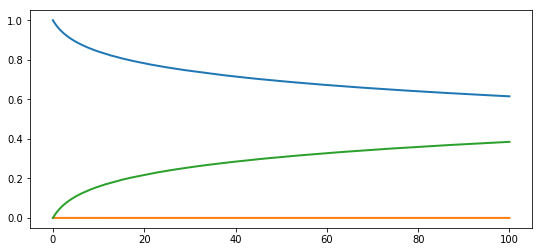

In [4]:
def robertson(t, y): 
    k1 = 0.04
    k2 = 3e7
    k3 = 1e4
    ydot = [-k1*y[0] + k3*y[1]*y[2], k1*y[0] - k3*y[1]*y[2] - k2*y[1]**2, k2*y[1]**2]
    return ydot
sol = solve_ivp(robertson, [0, 100], [1, 0, 0], method='RK45')

pyplot.figure(figsize=(9.0, 4.0))  # set the size of the figure
pyplot.plot(sol.t, sol.y[0], '-', color='C0', linewidth=2);
pyplot.plot(sol.t, sol.y[1], '-', color='C1', linewidth=2);
pyplot.plot(sol.t, sol.y[2], '-', color='C2', linewidth=2);

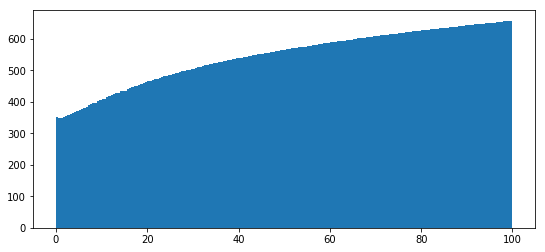

In [5]:
pyplot.figure(figsize=(9.0, 4.0))  # set the size of the figure
pyplot.hist(sol.t, bins=200);

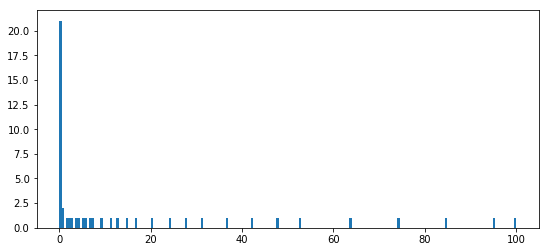

In [6]:
sol = solve_ivp(robertson, [0, 100], [1, 0, 0], method='BDF')
pyplot.figure(figsize=(9.0, 4.0))  # set the size of the figure
pyplot.hist(sol.t, bins=200);

### References

[1] Süli E., Mayers D. (2003). _An Introduction to Numerical Analysis_. Cambridge University Press. [link](http://newdoc.nccu.edu.tw/teasyllabus/111648701013/Numerical_Analysis.pdf)

[2] Hairer E., Norset S.P. _et al_ (2008). _Solving Ordinary Differential Equations - I - Nonstiff Problems_. Springer. (ask me for the book)

[3] Hairer E., Norset S.P. _et al_ (2008). _Solving Ordinary Differential Equations - II - Stiff and Differential-Algebraic Problems_. Springer. (ask me for the book)

[4] User Documentation for Sundials CVODE v3.1.2 [link](https://computation.llnl.gov/sites/default/files/public/cv_guide.pdf)